In [37]:
##### Code catlog
##### 12/09/2023 - Organize from One-node-final folder. Github has another final version, compare and update later
#####
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
from itertools import count

## Mathmatic Functions

In [38]:
import numpy as np

# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x

# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1
    return m
def rank(scores,agent):
    ranks =1
    for i in scores:
        if scores[agent] > scores[i]:
            ranks += 1
        elif scores[agent]  == scores[i]:
            ranks = ranks
    return ranks

# maximizing polarization only: \\bar{z}^T \\bar{z}
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean)
    return np.dot(np.transpose(z_mean), z_mean)[0,0]

# def obj_polarization_1(A, L, op, n):  #z_mean is the same as s_mean - according to Stanford paper theory
#     z = np.dot(A, op)
#     z_mean = mean_center(z, n)
#     return np.dot(np.transpose(z_mean), z_mean)[0,0]

# Calculate innate polarization
def obj_innate_polarization(s, n):
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]
# Parameters for the network


def network_anl(s,n,G,agent):

    print(str(agent)+' opinion: ' + str(s[agent]))
    print(str(agent)+' neighbors: '+ str(np.nonzero(G[agent])))

    s_aa = s[:, 0]
    my_dict = {index: value for index, value in enumerate(s_aa)}
    sorting_s = sorted(my_dict.items(), key=lambda x:x[1])
    sorted_S = dict(sorting_s)
    res = rank(sorted_S,agent)
    # printing result
    print("Opinion rank of this agent is : " + str(res))



    #print("___________________Max Analyze__________________________________________")
    nxG = nx.from_numpy_array(G)
    # G = nx.karate_club_graph()
    print("_______________Degree Centrality___________________")
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    res1 = rank(converted_dict,agent)
    print("rank of this agent is : " + str(res1))
    print(converted_dict[agent])

    # print(converted_dict)
    print("                           ")
    print("_______________Closeness Rank________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    res2 = rank(converted_dict1,agent)
    print("rank of this agent is : " + str(res2))
    print(converted_dict1[agent])
    # print(converted_dict1)
    print("                           ")
    print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict3 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict3 = dict(sortedDict3)
    res3 = rank(converted_dict3,agent)
    print("rank of this agent is : " + str(res3))
    print(converted_dict3[agent])
    # print(converted_dict3)

    print("                           ")

    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return x

    gap = gap(s,n)
    if gap[agent] < 0:
        my_gap = {index: value for index, value in enumerate(gap) if value<0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1])
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items())
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent's opinion extremity is ranked as: " + str(res4))
    else:
        my_gap = {index: value for index, value in enumerate(gap) if value>=0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items())
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent's opinion extremity is ranked as: " + str(res4))
    print("Agent's min_pref is ranked as: " + str(res4+res1))
np.set_printoptions(precision=3)

## Creating Network
### 1. Import Network

In [39]:
from karate import karate
from reddit import reddit

G, s, n = karate()
# G, s, n = reddit()

There are 34 agents
[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


### 2. Network Visualization

<Figure size 2000x2000 with 0 Axes>

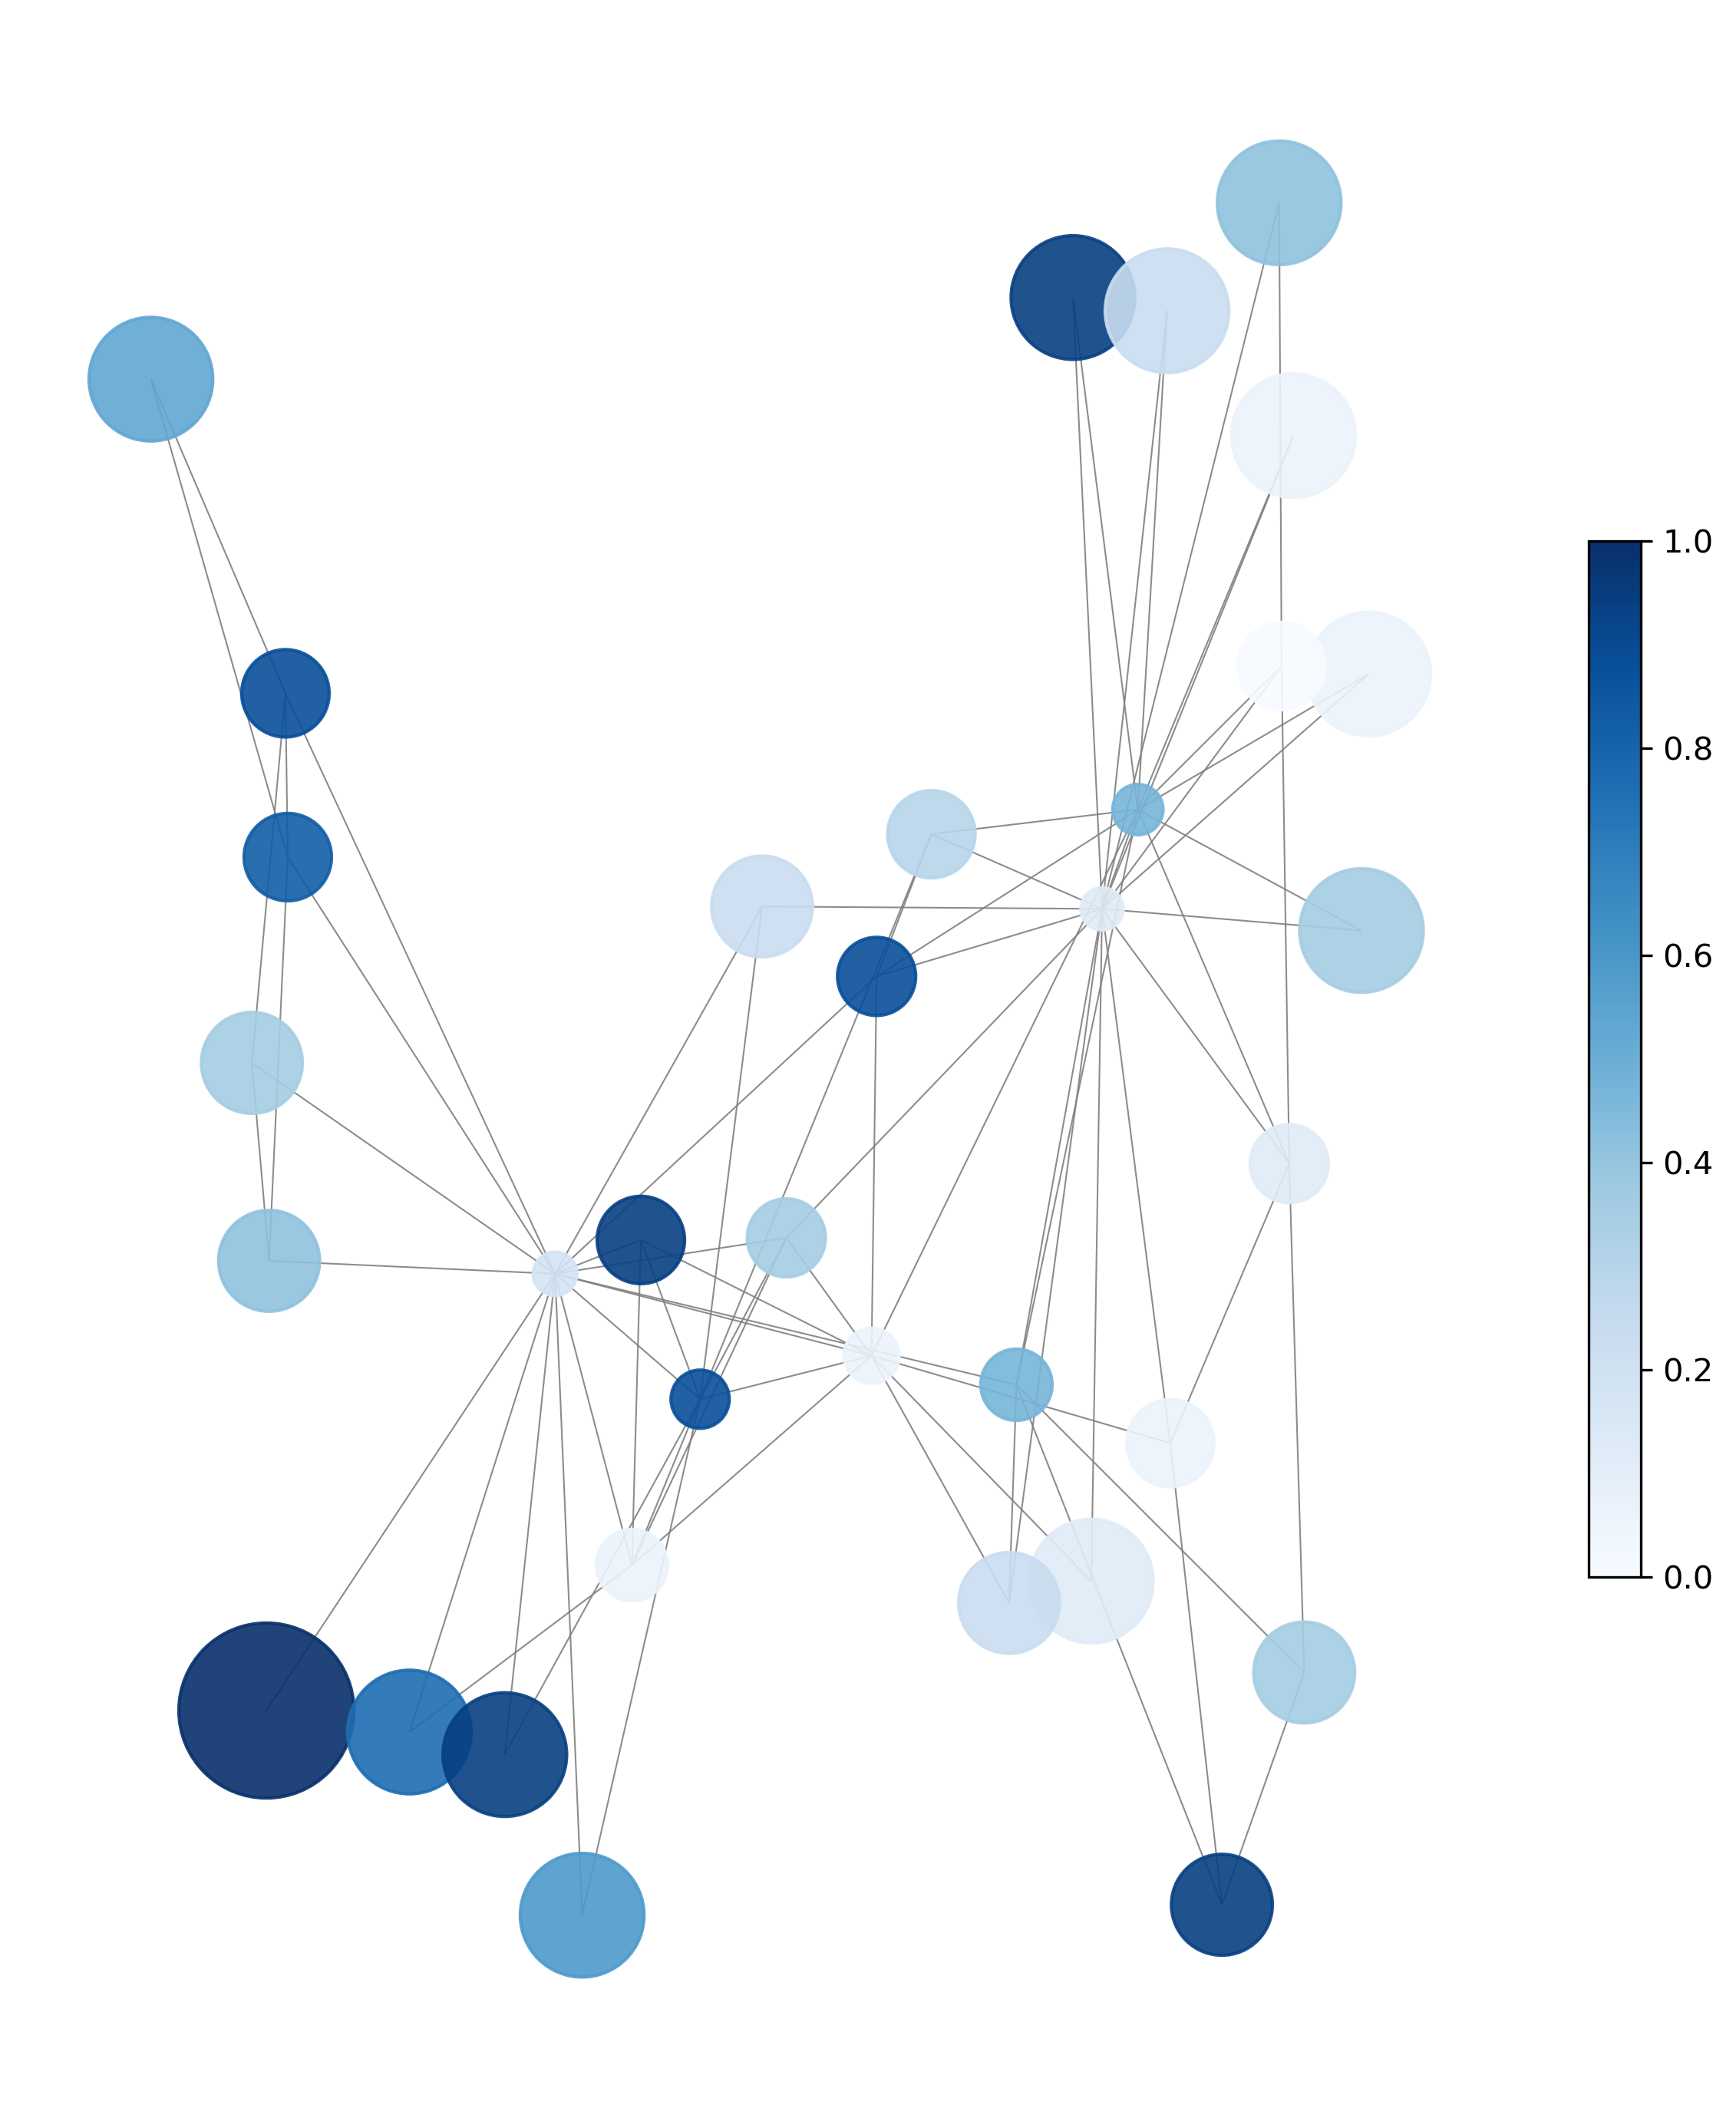

In [40]:
############################ Make Innate Opinion ################################
# Read network opinions
s_use = s.flatten()   # Convert array to a list for later operation
s_use = s_use.tolist()
new_s = [i * 30 for i in s_use]
df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2

######################### Calculate Key Values & Visualization #######################################3
L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)  Adjacency Matrix
m = num_edges(L, n)                    # call the function to calculate the number of edges
columnsum_ij = np.sum(A, axis=0)
nxG = nx.from_numpy_array(G)
plt.figure(figsize=(20, 20))

def node_edge(G, n):
    edges =[]
    for v in range(n):
        a = np.array(np.nonzero(G[v])[0])
        edge = len(a)
#         print(edge)
        edges.append(edge)

    return edges

node_edges = node_edge(G, n)


min_equi =[]
max_equi=[]

# create color map
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('Red')
    else:
        #color_map.append('#1f77b4')
        color_map.append('grey')


# create node color map value
s_use = s.flatten()
s_use = s_use.tolist()
new_s = [i * 30 for i in s_use]
df = pd.DataFrame(new_s, columns=['Opinion'])

# create node sizes
node_sizes =[]
for i in node_edges:
    node_size = 1/i*3000
    node_sizes.append(node_size)

# visualize the network in high resolution
plt.figure(figsize=(8, 9), dpi=300)  # Set the DPI for high resolution
# draw subgraph for highlights
my_pos = nx.spring_layout(nxG, k=0.3, seed = 2) #set a seed so the network will not give random layout
nx.draw(nxG, pos= my_pos,with_labels=False, node_color=df['Opinion'].astype(int), cmap=plt.cm.Blues,node_size= node_sizes, edge_color='grey', width=0.5, font_color='black',font_size=12, font_weight='bold', alpha=0.9)
#nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))


# visualize the network in high resolution
cbar = plt.colorbar(sm, shrink=0.5, ax=plt.gca())

## 3. Network Property Visualization

Text(0, 0.5, 'Number of Agents')

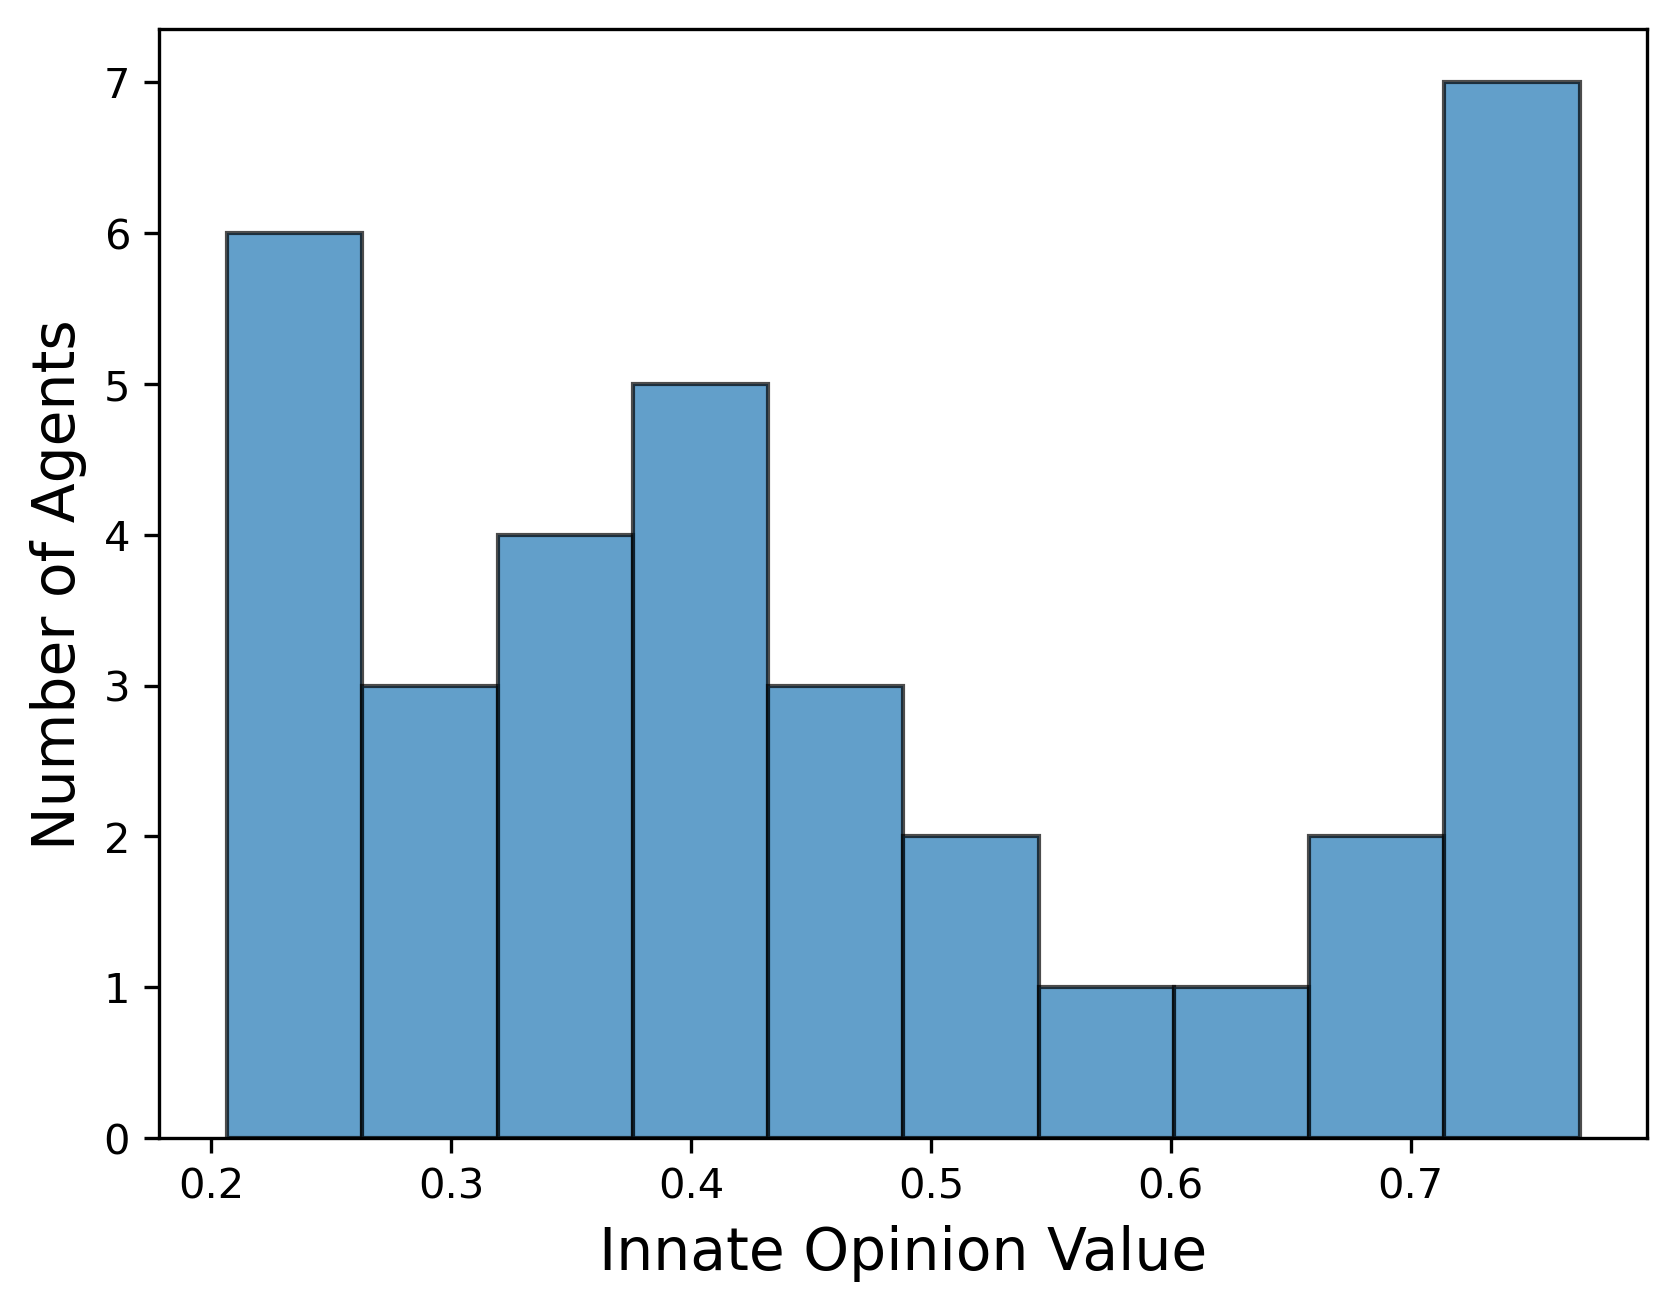

In [41]:
plt.figure(dpi=300)
# Create a histogram
plt.hist(s, bins=10, edgecolor='black', alpha=0.7)
# new_list = range(0, 3)
#plt.ylim(0,8)
#plt.yticks(range(0, 10, 2))
#Add labels and title
plt.xlabel('Innate Opinion Value',fontsize=14)
plt.ylabel('Number of Agents',fontsize=14)
# Save the figure as a high-quality PNG image
# plt.savefig('results/Reddit_opinion_histograms.png', dpi=800)  # Adjust dpi for higher quality
# plt.savefig('results/Karate_opinion_histograms.png', dpi=800)  # Adjust dpi for higher quality


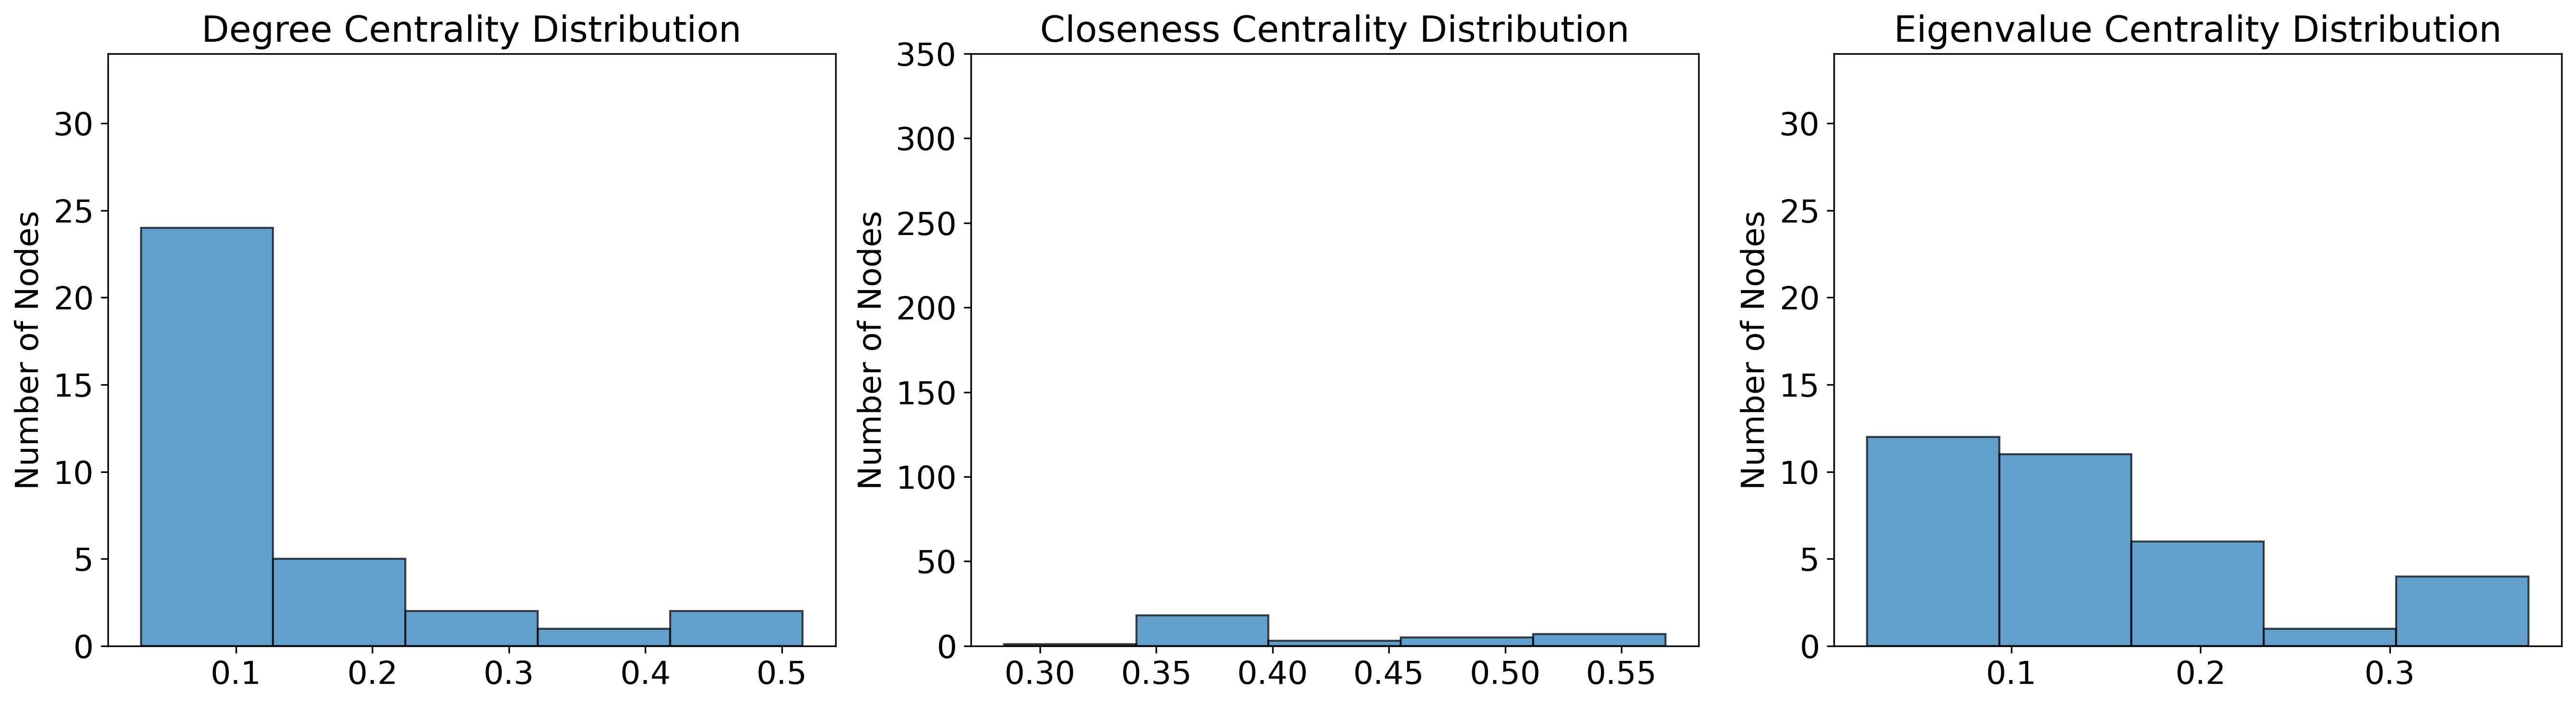

In [42]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate centrality measures
degree_centrality = nx.degree_centrality(nxG)
closeness_centrality = nx.closeness_centrality(nxG)
eigenvector_centrality = nx.eigenvector_centrality(nxG)

# Convert dictionaries to Pandas DataFrames
degree_df = pd.DataFrame(list(degree_centrality.values()), columns=['Degree Centrality'])
closeness_df = pd.DataFrame(list(closeness_centrality.values()), columns=['Closeness Centrality'])
eigenvector_df = pd.DataFrame(list(eigenvector_centrality.values()), columns=['Eigenvalue Centrality'])


# Plot histograms of centrality measures in a horizontal layout
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=300)  # Set DPI to 300 for higher resolution


# Degree Centrality Histogram
axs[0].hist(degree_df['Degree Centrality'], bins=5, edgecolor='black', alpha=0.7)
#print(degree_df['Degree Centrality'])
axs[0].set_title('Degree Centrality Distribution',fontsize=18)
#axs[0].set_xlabel('Degree Centrality')
axs[0].set_ylabel('Number of Nodes',fontsize=16)
axs[0].set_ylim(0, max(len(degree_df), len(closeness_df), len(eigenvector_df)))
#for Reddit visualization
#axs[0].set_ylim(0,350)
axs[0].tick_params(axis='x', labelsize=16)  # Font size for x-axis tick labels
axs[0].tick_params(axis='y', labelsize=16)  # Font size for y-axis tick labels


# Closeness Centrality Histogram
axs[1].hist(closeness_df['Closeness Centrality'], bins=5, edgecolor='black', alpha=0.7)
axs[1].set_title('Closeness Centrality Distribution',fontsize=18)
#axs[1].set_xlabel('Closeness Centrality')
axs[1].set_ylabel('Number of Nodes',fontsize=16)
axs[1].set_ylim(0, max(len(degree_df), len(closeness_df), len(eigenvector_df)))
#for Reddit visualization
axs[1].set_ylim(0,350)
axs[1].tick_params(axis='x', labelsize=16)  # Font size for x-axis tick labels
axs[1].tick_params(axis='y', labelsize=16)  # Font size for y-axis tick labels


# Eigenvalue Centrality Histogram
axs[2].hist(eigenvector_df['Eigenvalue Centrality'], bins=5, edgecolor='black', alpha=0.7)
axs[2].set_title('Eigenvalue Centrality Distribution',fontsize=18)
#axs[2].set_xlabel('Eigenvalue Centrality')
axs[2].set_ylabel('Number of Nodes',fontsize=16)
axs[2].set_ylim(0, max(len(degree_df), len(closeness_df), len(eigenvector_df)))

#for Reddit visualization
#axs[2].set_ylim(0,350)
#axs[2].set_xticklabels(['{:.1f}'.format(x) for x in axs[0].get_xticks()])  # Set x-axis precision to 1
# Setting font size for tick labels on both axes
axs[2].tick_params(axis='x', labelsize=16)  # Font size for x-axis tick labels
axs[2].tick_params(axis='y', labelsize=16)  # Font size for y-axis tick labels

plt.tight_layout()
# Save the figure as a high-quality PNG image
plt.savefig('results/Reddit_centrality_histograms.png', dpi=800)  # Adjust dpi for higher quality

plt.show()




In [43]:
# Analyze node feature
nod_ind= 29 #index of node - start with 0

network_anl(s,n,G,nod_ind)
# print(s)
print("__Minimum Eigen_value Centrality__")
print(np.min(eigenvector_df['Eigenvalue Centrality']))
print("__Maximum opinion_")
print(min(s))

29 opinion: [0.207]
29 neighbors: (array([23, 26, 32, 33]),)
Opinion rank of this agent is : 1
_______________Degree Centrality___________________
rank of this agent is : 19
0.12121212121212122
                           
_______________Closeness Rank________________________
rank of this agent is : 16
0.38372093023255816
                           
_______________Page Rank_____________________________
rank of this agent is : 21
0.13496528673866567
                           
Agent's opinion extremity is ranked as: 1
Agent's min_pref is ranked as: 20
__Minimum Eigen_value Centrality__
0.02363479426059687
__Maximum opinion_
[0.207]


### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [44]:
# Calculate network polarization

op = s
y = mean_center(s,n)
# print(y)
# Polarization before opinion dynamics
innat_pol = np.dot(np.transpose(y), y)[0,0]
print('Innate_polarization:')
print(innat_pol)

# Polarization after opinion dynamics
equ_pol = obj_polarization(A, L, s, n)
print('Equi_polarization:')
print(equ_pol)

di = equ_pol-innat_pol
print("Difference:")
print(di)

Innate_polarization:
1.1743186020487546
Equi_polarization:
0.15967526924290512
Difference:
-1.0146433328058495


### Testing players' behavior

In [45]:
def random_play(s, n):  # player randomly choose an agent and randomly change the agent
    op = copy.copy(s)

    v = random.randint(0, n-1)  # randomly select an agent index
#     print(v)
    new_op = random.randint(0, 1)  # randomly select an opinion between 0 and 1
#     print(new_op)

    # Store old opinion
    old_opinion = op[v, 0]

    # update the opinion
    op[v, 0] = new_op
#     print('Only 1 opinion changed')
#     print(op)
    print("    "+"Agent" + str(v) + " 's opinion " +
          str(old_opinion) + " changed to " + str(new_op))
    por = obj_polarization(A, L, op, n)

    # restore op op array to innate opinion
    op[v] = old_opinion
    print("Network reaches equilibrium Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v, new_op, por)

In [46]:
def random_play1(s, n):  # player randomly choose an agent and randomly change the agent
    op = copy.copy(s)
#     max_opi_option = random.uniform(0, 1)   # options that maximizer have

    v = random.randint(0, n-1)  # randomly select an agent index
#     print(v)
#     v = 1
    # randomly select an opininon between 0 and 1
    new_op = random.uniform(0, 1)
    # new_op = 0
#     print(new_op)

    # Store old opinion
    old_opinion = op[v, 0]

    # update the opinion
    op[v, 0] = new_op
#     print('Only 1 opinion changed')
#     print(op)
    print("    "+"Agent" + str(v) + " 's opinion " +
          str(old_opinion) + " changed to " + str(new_op))
    por = obj_polarization(A, L, op, n)

    # restore op op array to innate opinion
    op[v] = old_opinion
    print("Network reaches equilibrium Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v, new_op, por)

In [47]:
def maximizer_fir_play(s, n, min_touched):
    """
    maximizer first-time play, greedy algorithm
    """
    op = copy.copy(s)

    print('Maximizer Play')

    # The best choice among all opinions and vertexs, function is in "pure_strategy_selection.ipynb"
    max_champion = choose_max_vertex(op, n, min_touched)
    # find agent v1, and max_opinion that can maxmize the equi_polarization(max_pol)
    (v1, max_opinion, innate_obj, max_pol) = max_champion

    if v1 == None:   # if maximizer cannot find one
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
#         print('v1', 'changed_opinion', 'innate_obj', 'obj')
#         print(max_champion)

        # Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]
        # change the agent's opinion with best action(agent v1, max_op)
        op[v1, 0] = max_opinion
        # check if agent's opinionis is changed or not
        print("    "+"Agent" + str(v1) + " 's opinion " +
              str(old_opinion_max) + " changed to " + str(max_opinion))
        print("Network reaches equilibrium Polarization: " + str(max_pol))

    return (v1, max_opinion, max_pol)

In [48]:
def minimizer_fir_play(s, n, max_touched):
    """
    minimizer first-time play, greedy algorithm
    """

    op = copy.copy(s)
    print('_______________________')
    print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)

    min_champion = choose_min_vertex(op, n, max_touched)
    (v2, min_opinion, innat_equi_por, min_pol) = min_champion

   # Store innate_op of the min_selected vertex
    old_opinion_min = op[v2, 0]

    if v2 == None:
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")

        # change the agent's opinion
        # -------------------------------------------------> store minimize strategy
        op[v2, 0] = min_opinion

        print("    "+"Agent" + str(v2) + " 's opinion " +
              str(old_opinion_min) + " changed to " + str(min_opinion))

        print("Network reaches equilibrium Polarization: " + str(min_pol))
#         print('2 opinion changed')
#         print(op)

    return (v2, min_opinion, min_pol)

In [49]:
# max_touched = []
# min_touched = []
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
# print(v2, min_opinion, min_pol)

In [50]:
## Testing above functions
# min_touched=[]
# max_touched=[]
# # Game start from maximizer random play
# print('Maximizer random selection')
# (v1, max_opinion, max_pol) = random_play(s,n)
# max_touched.append(v1)
# # print('v1, max_opinion, max_pol')
# # print(v1, max_opinion, max_pol)
# # store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history


# # Game start from minimizer random play
# print('Minimizer random selection')
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
# min_touched.append(v2)



In [51]:
# Row are Column are depended on min and max's choice: agent v and opinion
def row_index(v2, min_opinion):
    row = 11*v2 + min_opinion*10
    return int(row)
def column_index(v1,max_opinion):
    column = 2*v1 + max_opinion
    return int(column)  #the python dataframe index

### Mixed Strategy Payoff


In [52]:
def make_payoff_row(op1,v2):
    payoff_row = np.zeros(2*n)

#     print('one opinion changed -min')
#     print(op1)
    for column in range(2*n):
#         print(column)
        v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
        max_opinion = column%2
#         print(v1, max_opinion)
        # update the maximizer's change to the opinion array that has changed by minimizer(op1)
        op2 = copy.copy(op1)
#         temp = op1[v1]
        op2[v1,0] = max_opinion

        # calculate the polarization with both max and min's action
        payoff_row[column] = obj_polarization(A, L, op2, n)
#         op1[v1,0] = temp # restore
#         print(op2,payoff_row[column])

    # when v1 == v2, the polarization should be negative for max, infinet for min.
    #######################ZERO SUM when v1==v2, the polarization is innate polarization########################
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    O_P = obj_polarization(A, L, s, n)
    payoff_row[j_1] = O_P
    payoff_row[j_2] = O_P

    return payoff_row

### Minimizer Mixed Strategy

In [53]:
def mixed_min_polarization(s, v2, weight_op, fla_max_fre):
    """
    Calculate polarization of minimizer's Mixed Strategy
    """

    op1 = copy.copy(s)  # make a copy of the innate opinion array
    op1[v2, 0] = weight_op  # then only updated by minimizer's current change
#     print('Min update')
#     print(v2, weight_op)
    # calculate the polarization with both min(did here) and max's action(in make_payoff_row)
    # the vector list out 2*n payoffs after min's action combine with 2*n possible max's actions
    payoff_row = make_payoff_row(op1, v2)
    # print(payoff_row)

    # Replace the the column_index of agent v2 with 100 for min - NO NEED TO REPLACE NOW

#     print('Min Payoff Row')
#     print(payoff_row)
    # calculate fictitious payoff - equi_min
    # fla_max_fre recorded the frequency of each maximizer's action, frequency sum = 1
    payoff_cal = payoff_row * fla_max_fre
    # payoff (2*n array) * maximizer_action_frequency (2*n array)

    # add up all, calculate average/expected payoff
    mixed_pol = np.sum(payoff_cal)


#     print('min_mixed_polarization')
#     print(mixed_pol)
    # Replace the the column_index of agent v2 with 100 for min

    return (mixed_pol, payoff_row)

In [54]:
def derivate_s(op, n, v2):
    # op - opinion array that updated by maximizer
    c = [1/n] * n
#     print(c)
    sum_term = 0
    j = 0

    sum_term = np.dot(np.dot((A-c), (A[v2]-c)), op)  # sum up all terms

    # exclude the term that j = v2
    term_out = op[v2]*np.dot((A[v2]-c), (A[v2]-c))
    sum_s = sum_term - term_out    # numerator

    s_star = -sum_s/np.dot((A[v2]-c), (A[v2]-c))
    s_star = s_star[0]  # take value out of array
    min_opinion = min(max(0, s_star), 1)

#     print('Min opinion-should be unique')
#     print(min_opinion)
    return min_opinion

# Print out weighted opinion proved that we need to do this step insetead of min_mixed_opinion - we are weighting
# different min_opinion here


def min_mixed_opinion_1(s, n, v2, fla_max_fre):

    weight_op = 0

    # loop for each max_action(in total 2*n)
    for column in range(2*n):

        if fla_max_fre[column] != 0:
            v1 = int(column/2)  # i.e., column 11 is agent 5, opinion 1
            max_opinion = column % 2
            op = copy.copy(s)
            op[v1] = max_opinion
#             print(op)

#             print('Weight')
#             print(fla_max_fre[column])
            # find min_s_star for each max_action
            min_opinion = derivate_s(op, n, v2)
            op1 = copy.copy(op)
            # after max action, update min action on opinion array
            op1[v2] = min_opinion
#             print(min_opinion)
            min_por = obj_polarization(A, L, op1, n)
            t = 0
            weight_op = weight_op + \
                fla_max_fre[column]*min_opinion  # sum up p_i*s_i

    (mixed_por, payoff_row) = mixed_min_polarization(
        s, v2, weight_op, fla_max_fre)
#     print('Weighted polarization')
#     print(mixed_por)

    return (weight_op, payoff_row, mixed_por)

In [55]:
# Minimizer search: Go through each agent

def mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre):
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = copy.copy(s)
    op[v1,0] = max_opinion
#     print('Check if op has been updated by Maximizer')
#     print(op)
    maxup_por = obj_polarization(A, L, op, n) #min_por- set a standard to compare with pol after min's action
    min_por = 1000 # use the infinite big min_por
#     print('check maxup por')
#     print(maxup_por)
#     payoffs = []    # create an empty list to store all polarizations
    champion = (None, None, 0, None)  # assume the best action is champion

    all = list(range(n))    # for all agent
    C1 = [x for x in all]  # for the vertice that Maximizer has not touched

    for v2 in C1:
#         print('_________________________________')
#         print('Min start with agent '+ str(v2) )
        ################################# for ZERO SUM ##########################################
        if v2 == v1:
            (por, payoff_row) = mixed_min_polarization(s, v2, s[v2],fla_max_fre)
            changed_opinion = s[v2,0] # doesn't change the innate opinion, keep the polarization as inante polarization
#             print('Weighted polarization')
#             print(por)
#             print("Maxup por, min_por:", maxup_por, por)
#         #########################################################################################
        else:
            (changed_opinion, payoff_row, por) =  min_mixed_opinion_1(s, n, v2, fla_max_fre) # find the best new_op option
    #         print('changed opinion, por, Maxup_por')
    #         print(changed_opinion, por, maxup_por)

#             print("Maxup por, min_por:", maxup_por, por)
        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
                                 # update the recent option as champion
            champion = (v2, changed_opinion, payoff_row, min_por)
#             print("Maxup por, min_por:", min_por, por)
#         else:
#             print('Innate polarization is smaller than Min action')



    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


In [56]:
def mixed_min_play(s, v1, max_opinion, n, max_touched, fla_max_fre):
    """
    Op has been updated by maximizer, fla_max_fre includes max's hisotry, so minimizer react to the innate op after that
    """

    #     print('_______________________')
    #     print('Minimizer Play')
    #     print('Only 1 opinion changed')
    #     print(op)

    min_champion = mixed_choose_min_vertex(
        s, n, v1, max_opinion, max_touched, fla_max_fre)
    (v2, min_opinion, payoff_row, min_pol) = min_champion

    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")
#         print('v2', 'changed_opinion', 'innate_obj', 'obj')
#         print(v2, min_opinion, innat_equi_por, min_pol)

        # Store innate_op of the min_selected vertex
        old_opinion_min = op[v2, 0]

        print("    "+"Agent" + str(v2) + " 's opinion " +
              str(old_opinion_min) + " changed to " + str(min_opinion))
#         print('fla_max_fre')
#         print(np.nonzero(fla_max_fre))
#         print(fla_max_fre [np.nonzero(fla_max_fre)])


#         print("Payoff row")
#         print(payoff_row)
#         print("Network reaches equilibrium Polarization: " + str(min_pol))
#         print('2 opinion changed')
    return (v2, payoff_row, min_opinion, min_pol)

In [57]:
## Test the code
# print(max_touched)
# (v2, payoff_row, min_opinion, polarization) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)
# # print('v2, payoff_row, min_opinion, polarization')
# # print(v2, payoff_row, min_opinion, polarization)

### Maximizer Mixed Strategy

In [58]:
def mixed_max_polarization(payoff_matrix,v1,max_opinion,fla_min_fre):
    """
    Op has been updated by minimizer, fla_min_fre includes min's history, so maximizer react to the innate op after that
    """

    # create payoff matrix for maxmizer
    column = int(column_index(v1,max_opinion))
#     print(payoff_matrix)
#     print("column"+str(column))
    payoff_vector = payoff_matrix[:,column]

#     print('payoff vector')
#     print(payoff_vector)

    #calculate fictitious payoff - equi_max
    payoff_cal = payoff_vector * fla_min_fre #payoff * frequency

#     print('max_payoff_calculation')
#     print(payoff_cal)
    mixed_pol = np.sum(payoff_cal) # add up
#     print("Max_mixed_polarization")
#     print(mixed_pol)

    return mixed_pol

In [59]:
# mixed_pol = mixed_max_polarization(payoff_matrix,v1,max_opinion, fla_min_fre)

In [60]:
def max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre):
    """
    determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization
    """

    # create a two_element array to store polarization value of each option
    por_arr = np.zeros(2)

    # Maximizer has two options to change agent v1's opinion
    max_opi_option = [0, 1.0]

    # objective if set opinion to 0, 1.0
    j = 0
    for new_op in max_opi_option:
        #         print('change op to '+ str(i/10))
        max_opinion = new_op

        por_arr[j] = mixed_max_polarization(
            payoff_matrix, v1, max_opinion, fla_min_fre)

        j = j + 1   # index increase 1, put the polarization in array

#     print('Polarization Options')
#     print(por_arr)

    # the index of maximum polarization = max_opinion --[0,1]
    maxmize_op = np.argmax(por_arr)
    # find the maximum polarization in the record
    max_por = np.max(por_arr)

#     print('new_op', 'innat_equi_por', 'max_por')
#     print(maxmize_op, innat_equi_por, max_por)

    return (maxmize_op, max_por)

In [61]:
def mixed_choose_max_vertex(payoff_matrix, op, n, min_touched, fla_min_fre):
    """
    determine which agent maximizer should select to maximizer the equilibrium polarization
    """
#     print('Check if op has been updated by minimizer')
#     print(op)
    # use "innate"(after min action) polarization as a comparable standard to find max_por
    max_por = 0
    # store innate min_update polarization
    minup_por = obj_polarization(A, L, op, n)
#     print('check minup por')
#     print(minup_por)
    champion = (None, None, max_por)  # assume champion is the best action

    all = list(range(n))    # for all agent
    C1 = [x for x in all]  # for the vertice that Minimizer has not touched
    for v1 in C1:
        #             print('Maximizer start from agent'+str(v1))
        (changed_opinion, por) = max_mixed_opinion(
            payoff_matrix, n, v1, fla_min_fre)

        if v2 == v1:
            # doesn't change the innate opinion, keep the polarization as inante polarization
            changed_opinion = s[v2, 0]

#             print('changed_opinion, por, minup_por')
#             print(changed_opinion, por,minup_por)

        if por > max_por:  # if the polarization of most recent action > maximum polarization of previous actions
            max_por = por
            # save the this action as champion
            champion = (v1, changed_opinion, max_por)
#             else:
#                 print('Innate polarization is bigger than max action')

    return (champion)

In [62]:
def mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre):
    op = copy.copy(s)   # op is a copy of innate opinion

    #update innat opinion
    op[v2,0] = min_opinion  # Op has been updated by minimizer, so maximizer react to the innate op after that


    max_champion = mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre) # The best choice among all opinions and vertexs
    (v1, max_opinion, max_pol) = max_champion

    if v1 == None:
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
        #Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]

    if v1 == v2:
        max_opinion = s[v1,0] #If select the same agent, doesn't change the opinion

        ## check if agent's opinionis is changed or not
    print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
#         print("Network reaches equilibrium Polarization: " + str(max_pol))
#         print('2 opinion changed')
#         print(op)

    return(v1, max_opinion, max_pol)

In [63]:
# # # Testing function -- NO NEED TO RUN
# min_touched = []
# v2 = 0
# min_opinion = 0
# # payoff_matrix = np.empty((0, 2*n), float)
# b = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
# print('v1,max_opinion,max_pol')
# print(b)

### Testing Player's Behavior

# 5. Innate Op and Game

# Fictitious Play Start !


In [64]:
op = s
y = mean_center(s, n)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0, 0]
print('Innate_polarization:')
print(innat_pol)

# Test equilibrium polarization
equ_pol = obj_polarization(A, L, op, n)
print('Equi_polarization:')
print(equ_pol)

di = equ_pol-innat_pol
print("Difference:")
print(di)

Innate_polarization:
1.1743186020487546
Equi_polarization:
0.15967526924290512
Difference:
-1.0146433328058495


In [65]:
# Set network saving parameter
Network = 'Karate'
# memory = 1


# with open('Network_'+str(Network)+'.txt', "a") as fi:
#     print('Innate Opinion', file=fi)
#     print(s, file=fi)
#     print('Adjacency Matrix', file=fi)
#     print(G,file=fi)

# Game Preparation
def push(obj, element):
    if len(obj) >= memory:
        obj.pop(0)
        print('pop')
    obj.append(element)
    return obj

In [66]:
# Game Parameters
Game_rounds = 2  # Rounds + 1- use for printing data
memory = 0  # Game parameter - for zero-sum, the memory is always 0

# Preparation for the game
op = copy.copy(s)
payoff_matrix = np.empty((0, 2*n), float)
max_history = np.zeros([n, 2])  # n*2 matrix, agent i & opinion options
# append a list of (agent i, min_opinion), min_opinion can be any value
min_history = []
#     print(type(min_history))

max_history_last_100 = np.zeros([n, 2])
min_history_last_100 = []

max_touched = []
min_touched = []
min_touched_all = []
min_touched_last_100 = []
print('min_touched')
print(min_touched)


# Game start from maximizer random play
print('Maximizer first selection')
(v1, max_opinion, max_pol) = random_play(
    op, n)   # Maximizer start with random action
# (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched) # Maximizer start with greedy action
# (v1, max_opinion, max_pol) = (29, 0, 0) # Fix the initial point

First_max = (v1, max_opinion, max_pol)  # Save the first action

max_touched.append(v1)    # save Maximizer's action history

# store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history
##################################### Remove first random action from the history############
max_history[v1, int(max_opinion)] = max_history[v1, int(max_opinion)] + 1

print('history at spot')
print(max_history[v1, int(max_opinion)])

# its frequency, only played  1 time so far, divided by 1
max_frequency = max_history/1
# print('fre_max at spot')
# print(max_frequency[v1,int(max_opinion)])

# flatten the n*2 matrix to a 2n*1 matrix
fla_max_fre = max_frequency.flatten()
# so we can multiply the freuency (2n*1)with payoff array (1*2n)
# to get average payoff of fictitious play
print('fre_max at spot')
print(fla_max_fre)

# the frequency of maximizer's most recent action (v1,max_opinion)
column = int(column_index(v1, max_opinion))

print(fla_max_fre[column])

# print(np.shape(fla_max_fre.shape))


# if game start from minimizer random play - make sure two random play are not same agent!!!
print('Minimizer first selection')
(v2, min_opinion, min_pol) = random_play(op, n)
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,min_touched)

# (v2, min_opinion, min_pol) = (16, 1, 0.01)
First_min = (v2, min_opinion, min_pol)

if v1 == v2:   # if Max and Min randomly selected the same agent, then we need to restart - cannot choose same agent
    sys.exit()

# Minimizer start with greedy play
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)

min_touched.append(v2)


# store minimizer play history
min_history.append((v2, min_opinion))
print('min_history')
print(min_history)


# return a dictionary include {'min_option': count of this choice}
counter = collections.Counter(min_history)
print(counter)
# return only frequency of all min options in order
fla_min_fre = np.array(list(counter.values()))/1
#     print('fla_min_fre')
#     print(fla_min_fre)


(a, payoff_row) = mixed_min_polarization(s, v2, min_opinion, fla_max_fre)
payoff_matrix = np.vstack([payoff_matrix, payoff_row])
#     print('Payoff Matrix')
#     print(payoff_matrix)
print('fla_min_fre at the spot')
min_counter = dict(counter)
print(min_counter)
print(min_counter[(v2, min_opinion)])
#     print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)


equi_min = min_pol
equi_max = max_pol
# print(equi_min)
# print(equi_max)


Flag = 0

i = 0
while Flag == 0:
    i = i + 1
    print("Game " + str(i))
    print("_____________________")

#     if max_pol == min_pol:
    if i == Game_rounds:            # i == # of iterations you want to run + 2
        # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration
        print('min_recent_'+str(memory)+'_touched')  # then stop at Game 202
        print(min_touched)
        print('max_recent_'+str(memory)+'_touched')
        print(max_touched)
        print('Min last 100 action')
        print(min_touched_last_100)

        break

    elif equi_min == equi_max:
        print("Reached Nash Equilibrium at game" +
              str(i) + "and Equi_Por = " + str(equi_min))
        print('max_distribution')
        print(max_frequency)
        print('min_distribution')
        print(fla_min_fre)
        Flag = 1
        break
    # maximizer play
    else:
        if i == Game_rounds-100:  # if Game_round = 200, after 100 iteration, Game 101 print previous historical result
            #             max_touched_100 = max_touched
            #             min_touched_100 = min_touched
            #             max_fre_100 = max_frequency  # store the max_frequency of first 100 iterataions
            #             print('max_history')
            #             print(max_history)
            #             min_fre_100 = fla_min_fre  # max_frequency of first 100 iterations
            #             print('min_history')
            #             print(min_history)
            # Remove max frequncy less than 0.1--
            max_history_last_100 = np.zeros([n, 2])
            min_history_last_100 = []
            min_touched_last_100 = []

        (v1, max_opinion, equi_max) = mixed_max_play(
            payoff_matrix, s, v2, min_opinion, n, min_touched, fla_min_fre)
        max_touched = push(max_touched, v1)
#         print('min_touched')
#         print(min_touched)
#         print('max_touched')
#         print(max_touched)
#             print('equi_max')
#             print(equi_max)
#         print(v1, max_opinion, max_pol)
        # cumulate strategy
        max_history[v1, int(max_opinion)] = max_history[v1,
                                                        int(max_opinion)] + 1

        max_history_last_100[v1, int(
            max_opinion)] = max_history_last_100[v1, int(max_opinion)] + 1
#         print('max_history')
#         print(max_history)
# ________________________________________________________________
        max_frequency = max_history/(i+1)  # its frequency
#         print('max_distribution')
#         print(max_frequency)
    #     print(i+1)
        # flaten max_frequency to calculate average payoff
        fla_max_fre = max_frequency.flatten()
#             print('fla_max_fre')
#             print(fla_max_fre)
#         print('fre_max at spot')
#         print(fla_max_fre[column])
        # create payoff matrix for maxmizer
        row = int(row_index(v2, min_opinion))
        column = int(column_index(v1, max_opinion))

# _________________________________________________________________
#         ######################Visualize Maximizer's selection
#         La = scipy.sparse.csgraph.laplacian(G, normed=False)

#         nxG = nx.from_numpy_matrix(G)

#         color_map = []
#         for node in nxG:
#             if node == v1:
#                 color_map.append('Red')
#             else:
#                 color_map.append('Grey')

#         #nxG1 = nx.DiGraph(G)
#         nx.draw(nxG, node_color=color_map, with_labels=True,node_size = 50)
#         plt.figure(figsize=(200, 200))
#         plt.show()


# minimizer play
        (v2, payoff_row, min_opinion, equi_min) = mixed_min_play(
            s, v1, max_opinion, n, max_touched, fla_max_fre)
        min_touched = push(min_touched, v2)
        min_touched_all.append(v2)
        min_touched_last_100.append(v2)
#         print('min_touched')
#         print(min_touched)
#         print('equi_min')
#         print(equi_min)
#         print('max_touched')
#         print(max_touched)
        #         print(v2, min_opinion, min_pol)
        if (v2, round(min_opinion, 2)) in counter.keys():
            # if this min_option is in min_history, no need to update paryoff matrix, only update frequency
            payoff_matrix = payoff_matrix
#             print("Same history")
#             print((str(v2),str(min_opinion)))
        else:
            # if this is a new option, append to previous matrix
            payoff_matrix = np.vstack([payoff_matrix, payoff_row])
#             print('payoff_row')
#             print(payoff_row.shape)
#             print('payoff_matrix')
#             print(payoff_matrix.shape)
        min_history.append((v2, round(min_opinion, 2)))
        min_history_last_100.append((v2, round(min_opinion)))
        #         print('min_history')
        #         print(min_history)
        # return a dictionary include {'min_option': count of this choice}
        counter = collections.Counter(min_history)
        # print(counter)
#         print('counter.keys')
#         print(counter.keys())
        # return only frequency of all min options in order
        fla_min_fre = np.array(list(counter.values()))/(i+1)
#         print('fla_min_fre')
#         print(fla_min_fre)

#         print('fla_min_fre at the spot')
#         min_counter = dict(counter)
#         print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)

        # create payoff matrix for minimizer
        row = row_index(v2, min_opinion)
        column = column_index(v1, max_opinion)
        #     print('row, column')
        #     print(row, column)

        print("Not Reached Nash Equilibrium at Equi_Min = " +
              str(equi_min) + " and Equi_Max = " + str(equi_max))
#         print('min_distribution')
#         print(fla_min_fre)

        # Visualize Minimizer selection
#         La = scipy.sparse.csgraph.laplacian(G1, normed=False)

#         nxG = nx.from_numpy_matrix(G1)

#         color_map = []
#         for node in nxG:
#             if node == v2:
#                 color_map.append('Blue')
#             else:
#                 color_map.append('Grey')

#         #nxG1 = nx.DiGraph(G)
#         nx.draw(nxG, node_color=color_map, with_labels=True)
#         plt.figure(figsize=(25, 25))
#         plt.show()
#     return (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100)

min_touched
[]
Maximizer first selection
    Agent27 's opinion 0.2457746750273635 changed to 0
Network reaches equilibrium Polarization: 0.17795702467760224
history at spot
1.0
fre_max at spot
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
Minimizer first selection
    Agent12 's opinion 0.640120610637489 changed to 1
Network reaches equilibrium Polarization: 0.20176628891243625
min_history
[(12, 1)]
Counter({(12, 1): 1})
fla_min_fre at the spot
{(12, 1): 1}
1
Game 1
_____________________
                                
Maximizer finds its target agent:
    Agent16 's opinion 0.5120312044870241 changed to 1
pop
                                
Minimizer finds its target agent:
    Agent6 's opinion 0.720404905537744 changed to 0.027994758003278847
pop
Not Reached Nash Equilibrium at Equi_Min = 0.1574548381035994 and Equi_

/var/folders/v_/bcbsz84x67b3br6ml7_547jw0000gn/T/ipykernel_22938/3549878218.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  op1[v2, 0] = weight_op  # then only updated by minimizer's current change


In [67]:
# Experiment = 10

# Experiment_note = str('Note: This experiement has initial condition. Game round:'+str(Game_rounds)+'.')
# (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100) = all_fre_limited_touch(s, n)


In [68]:
# # MAXimizer's distribution of LAST 100 iteration
# print('Max_distribution_last_100')
# max_l100_fre = max_history_last_100/500
# print(max_l100_fre [np.nonzero(max_l100_fre)])
# print(np.nonzero(max_l100_fre))

max_fre = max_history/Game_rounds
print('Max_distribution_all')
print(max_fre[np.nonzero(max_fre)])
print([np.nonzero(max_fre)])
# print for small network
# # Print for Large Network
# print(np.nonzero(max_l100_fre))

print("__________________________________________")

# # MINimizer's Strategy in the last 100 round
# print('Min_distribution_last_100')
# counter_h=collections.Counter(min_touched_last_100)  #return a dictionary include {'min_option': count of this choice}
# print(counter_h.keys())
# counter=collections.Counter(min_touched_last_100)
# fla_min_fre = np.array(list(counter.values()))/(500) #return only frequency of all min options in order
# print('fla_min_fre')
# print(fla_min_fre)
# print(min_touched_last_100)


# return a dictionary include {'min_option': count of this choice}
counter_1h = collections.Counter(min_history)
# print(counter_1h.keys())
# return a dictionary include {'min_option': count of this choice}
counter_1 = collections.Counter(min_touched_all)

# return only frequency of all min options in order
fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds
print('Min_distribution_all')
print(fla_min_fre_1)
print(counter_1)

np.set_printoptions(precision=3)

# print(counter_1h)

Max_distribution_all
[0.5 0.5]
[(array([16, 27]), array([1, 0]))]
__________________________________________
Min_distribution_all
[0.5]
Counter({6: 1})


In [69]:
# agent = 18
# network_anl(s,n,G,18)
# network_anl(s,n,G,19)

In [70]:
# print(payoff_matrix)

In [71]:
import os
# Save the Network and Game Result to the file
# Create the 'results' directory if it doesn't exist
# if not os.path.exists('results'):
# os.makedirs('results')

os.makedirs('results', exist_ok=True)

# Save the files
Experiment = '1'
pd.DataFrame(payoff_matrix).to_csv(
    'results/Karate Payoff Matrix' + str(Experiment)+'.csv')
pd.DataFrame(min_touched_all).to_csv(
    'results/Karate Min Overall' + str(Game_rounds)+'.csv')
pd.DataFrame(min_history).to_csv(
    'results/Karate Min agent & op Overall' + str(Game_rounds)+'.csv')
pd.DataFrame(max_history).to_csv(
    'results/Karate Max Overall' + str(Game_rounds)+'.csv')
with open('results/' + 'Result'+str(Network)+'.'+str(Experiment)+'Pure.txt', "a") as f:
    #     print(Experiment_note, file=f)
    print('Initial Condition -(agent, opinion, pol)', file=f)
    print('Innate op'+str(s), file=f)
    print('Adjacency matrix' + str(G), file=f)
    print('Max:' + str(First_max), file=f)
    print('Min' + str(First_min), file=f)

    print("In the Last 100 Rounds", file=f)
    print('_____________________', file=f)

    # MAX distribution of LAST 100 iteration
    print('Max_distribution', file=f)
    max_l100_fre = max_history_last_100/100
    print(max_l100_fre[np.nonzero(max_l100_fre)], file=f)
    # print for small network
    # print(max_history_last_100, file=f)
    # # Print for Large Network
    print(np.nonzero(max_l100_fre), file=f)

    # MIN Strategy in the last 100 round
    # return a dictionary include {'min_option': count of this choice}
    counter = collections.Counter(min_touched_last_100)
    # print(counter)
    # return only frequency of all min options in order
    fla_min_fre = np.array(list(counter.values()))/100
#     print('Min_frequency', file=f)
#     print(list(counter.keys()), file=f)
    print('Min_distribution_last_100', file=f)
    print(fla_min_fre, file=f)
    # return a dictionary include {'min_option': count of this choice}
    counter_h = collections.Counter(min_history_last_100)
    print(counter_h, file=f)

    print('min_recent_'+str(memory)+'_touched',
          file=f)  # then stop at Game 202
    print(min_touched, file=f)
    print('max_recent_'+str(memory)+'_touched', file=f)
    print(max_touched, file=f)

    print('In Overall'+str(Game_rounds)+' Rounds', file=f)
    print('_____________________', file=f)

    # Max action Overall
    np.set_printoptions(precision=3)

    max_fre = max_history/Game_rounds
#     print('Max_frequency', file=f)
#     print(max_history, file=f)
    print('Max_distribution', file=f)
    print(max_fre[np.nonzero(max_fre)], file=f)
    print(np.nonzero(max_fre), file=f)

    # Min Strategy in the Overall
    # return a dictionary include {'min_option': count of this choice}
    counter_1 = collections.Counter(min_touched_all)
    # return only frequency of all min options in order
    fla_min_fre_all = np.array(list(counter_1.values()))/Game_rounds
    print('Min_dist_all', file=f)
    print(fla_min_fre_all, file=f)
    print('Min_distribution', file=f)
    # return a dictionary include {'min_option': count of this choice}
    counter_a = collections.Counter(min_history)
    print(counter_a, file=f)
#     print(payoff_matrix, file=f)

In [72]:
counter=collections.Counter(min_history)
print(counter)
fla_min_fre = np.array(list(counter.values()))/Game_rounds
print('fla_min_fre')
print(fla_min_fre)

Counter({(12, 1): 1, (6, 0.03): 1})
fla_min_fre
[0.5 0.5]
